In [1]:
import numpy as np
from numpy import random as rnd
from matplotlib import pyplot as plt
import warnings,datetime,os,time,math

import torch
import pandas as pd
import seaborn as sns

from keras.layers import Activation,Dense,LSTM,Dropout,BatchNormalization,Concatenate,Input
from keras.models import Model,Sequential

from itertools import product

from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import pickle,h5py,json

import urllib
from bs4 import BeautifulSoup
from lmfit import Model as lmmodel

sns.set()

C:\Users\Jan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
rootpath = '..\\..\\TF_data\\STOCKDATA\\Data\\DJIA\\'

In [3]:
df_dj = pd.read_csv(rootpath+'DJIA\\DJIA.csv',index_col='DATE',parse_dates=['DATE'])

df_dj['DJIA'] = df_dj['DJIA'].apply(lambda x: np.nan if x=='.' else float(x))
df_dj = df_dj.resample('MS').mean()

In [4]:
df = pd.read_csv(rootpath+'DJIA30\\all_stocks_2006-01-01_to_2018-01-01.csv',index_col='Date',parse_dates=['Date'])

df = df[['Open']].reset_index(drop=False).groupby('Date').mean().rename(columns={'Open':'0_AVG'})
df = df.resample('MS').mean()

In [5]:
date_min = max(df.index.min(),df_dj.index.min())
date_max = min(df.index.max(),df_dj.index.max())

In [6]:
df_dj = df_dj[date_min:date_max]
df = df[date_min:date_max]

In [7]:
for filename in os.listdir(rootpath+'DJIA30\\'):
    if filename.split('_')[0]=='all': continue
    cf = pd.read_csv(rootpath+'DJIA30\\'+filename,index_col='Date',parse_dates=['Date'])
    cf = cf[['Open']].reset_index(drop=False).groupby('Date').mean().rename(columns={'Open':filename.split('_')[0]})
    df[filename.split('_')[0]] = cf.resample('MS').mean()[date_min:date_max]

In [8]:
df['0_DJIA'] = df_dj

In [9]:
df = df[df.columns.sort_values()]

In [10]:
dfX = df.copy().drop(columns=['0_DJIA','0_AVG'])

In [11]:
lookback = 15

X = []
y = []

for colname in dfX.columns.tolist():
    for k in range(lookback,dfX.shape[0]):
        X.append(np.array([dfX[colname].values[k-lookback:k],df['0_DJIA'].values[k-lookback:k],df['0_AVG'].values[k-lookback:k]]))
        y.append(dfX[colname].values[k])

X = np.swapaxes(np.stack(X,axis=0),1,2).reshape(-1,lookback,3)
y = np.stack(y,axis=0).reshape(-1,1)

In [12]:
X0,X1,y0,y1 = train_test_split(X,y,test_size=0.2,shuffle=True)

In [13]:
input_layer = Input(shape=(lookback,3,))
lstm_layer = LSTM(units=128,activation='relu')(input_layer)
output_layer = Dense(units=1,activation='relu')(lstm_layer)

model = Model(inputs=input_layer,outputs=output_layer)

model.compile(optimizer='adam',loss='mse',metrics=['mse'])
model.fit(X0,y0,batch_size=5,epochs=3)

Epoch 1/3


1775/1959 [==========================>...] - ETA: 9:58 - loss: 10970.0527 - mean_squared_error: 10970.05 - ETA: 3:27 - loss: 146823.6048 - mean_squared_error: 146823.60 - ETA: 2:08 - loss: 93503.9457 - mean_squared_error: 93503.9457 - ETA: 1:23 - loss: 85625.9264 - mean_squared_error: 85625.92 - ETA: 56s - loss: 61689.0924 - mean_squared_error: 61689.0924 - ETA: 49s - loss: 54523.0350 - mean_squared_error: 54523.035 - ETA: 41s - loss: 46658.2052 - mean_squared_error: 46658.205 - ETA: 36s - loss: 46808.8163 - mean_squared_error: 46808.816 - ETA: 33s - loss: 43110.7161 - mean_squared_error: 43110.716 - ETA: 31s - loss: 51513.0307 - mean_squared_error: 51513.030 - ETA: 28s - loss: 61753.7159 - mean_squared_error: 61753.715 - ETA: 27s - loss: 60169.7687 - mean_squared_error: 60169.768 - ETA: 26s - loss: 62613.0577 - mean_squared_error: 62613.057 - ETA: 24s - loss: 71640.1825 - mean_squared_error: 71640.182 - ETA: 23s - loss: 67995.7019 - mean_squared_error: 67995.701 - ETA: 21s - loss: 661

1959/1959 [==============================] - ETA: 0s - loss: 34960.2470 - mean_squared_error: 34960.24 - ETA: 0s - loss: 34785.8202 - mean_squared_error: 34785.82 - ETA: 0s - loss: 34573.4076 - mean_squared_error: 34573.40 - ETA: 0s - loss: 34509.2854 - mean_squared_error: 34509.28 - ETA: 0s - loss: 34817.9462 - mean_squared_error: 34817.94 - ETA: 0s - loss: 34925.9629 - mean_squared_error: 34925.96 - ETA: 0s - loss: 34959.0416 - mean_squared_error: 34959.04 - ETA: 0s - loss: 34753.7225 - mean_squared_error: 34753.72 - ETA: 0s - loss: 34669.4423 - mean_squared_error: 34669.44 - ETA: 0s - loss: 34649.3663 - mean_squared_error: 34649.36 - ETA: 0s - loss: 34590.1891 - mean_squared_error: 34590.18 - ETA: 0s - loss: 34485.3216 - mean_squared_error: 34485.32 - ETA: 0s - loss: 34473.7556 - mean_squared_error: 34473.75 - 10s 5ms/step - loss: 34418.2087 - mean_squared_error: 34418.2087
Epoch 2/3


1855/1959 [===========================>..] - ETA: 12s - loss: 12622.6006 - mean_squared_error: 12622.600 - ETA: 11s - loss: 8845.6403 - mean_squared_error: 8845.6403  - ETA: 9s - loss: 6675.9908 - mean_squared_error: 6675.990 - ETA: 9s - loss: 10550.8027 - mean_squared_error: 10550.80 - ETA: 8s - loss: 17515.6342 - mean_squared_error: 17515.63 - ETA: 9s - loss: 16255.0859 - mean_squared_error: 16255.08 - ETA: 9s - loss: 15481.7737 - mean_squared_error: 15481.77 - ETA: 9s - loss: 14836.6972 - mean_squared_error: 14836.69 - ETA: 9s - loss: 19174.0742 - mean_squared_error: 19174.07 - ETA: 9s - loss: 22746.5473 - mean_squared_error: 22746.54 - ETA: 9s - loss: 22286.7306 - mean_squared_error: 22286.73 - ETA: 9s - loss: 26818.4567 - mean_squared_error: 26818.45 - ETA: 9s - loss: 27619.4372 - mean_squared_error: 27619.43 - ETA: 8s - loss: 25926.0028 - mean_squared_error: 25926.00 - ETA: 8s - loss: 24304.1410 - mean_squared_error: 24304.14 - ETA: 8s - loss: 23566.1477 - mean_squared_error: 235

1959/1959 [==============================] - ETA: 0s - loss: 29835.6282 - mean_squared_error: 29835.62 - ETA: 0s - loss: 30014.3742 - mean_squared_error: 30014.37 - ETA: 0s - loss: 29763.6402 - mean_squared_error: 29763.64 - ETA: 0s - loss: 29537.2210 - mean_squared_error: 29537.22 - 9s 4ms/step - loss: 29323.7668 - mean_squared_error: 29323.7668
Epoch 3/3
1959/1959 [==============================] - ETA: 6s - loss: 12786.1230 - mean_squared_error: 12786.12 - ETA: 6s - loss: 8025.8333 - mean_squared_error: 8025.8333 - ETA: 5s - loss: 22701.8845 - mean_squared_error: 22701.88 - ETA: 5s - loss: 25462.4882 - mean_squared_error: 25462.48 - ETA: 5s - loss: 25366.9116 - mean_squared_error: 25366.91 - ETA: 5s - loss: 22434.9335 - mean_squared_error: 22434.93 - ETA: 5s - loss: 27165.8092 - mean_squared_error: 27165.80 - ETA: 5s - loss: 25726.1380 - mean_squared_error: 25726.13 - ETA: 5s - loss: 24473.6360 - mean_squared_error: 24473.63 - ETA: 6s - loss: 26644.5132 - mean_squared_error: 26644.5

In [73]:
model.evaluate(X1,y1)

In [109]:
pca = PCA()
pca_dec = pca.fit_transform(X.reshape(-1,15*3))

print(pca.explained_variance_ratio_[:3])

[0.95363217 0.02360261 0.00673828]


In [120]:
t = pd.DataFrame()
t['PCA0'] = pca_dec[:,0] 
t['PCA1'] = pca_dec[:,1]

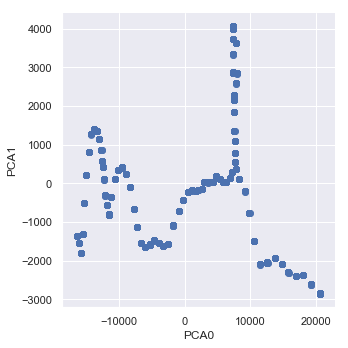

In [122]:
sns.lmplot(x='PCA0',y='PCA1',data=t,fit_reg=False)

In [116]:
t

,0,1
0,-16400.847630,0.0
1,-16064.856008,0.0
2,-15678.719843,1.0
3,-15496.860505,1.0
4,-15271.577736,1.0
...,...,...
2444,15768.305496,0.0
2445,16861.132671,0.0
2446,18000.982776,1.0
2447,19230.230072,0.0
